In [1]:
using Pkg
using Distributions
#Pkg.add("Optim")
#Pkg.add("PyPlot")
#Pkg.add("LinearAlgebra")

using Optim
using PyPlot
using LinearAlgebra

┌ Info: Recompiling stale cache file /home/erichschulman/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/erichschulman/.julia/compiled/v1.0/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1190
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1192


In [2]:
function market_shares(p,alpha)
    return exp.(-alpha.*p) / (1 + sum( exp.(-alpha.*p) ) )
end


function mco_profits(p,phi,mu,alpha)
    return market_shares(p,alpha) .* ( p - mu .* phi )
end


function price_profits(phi,mu,alpha)
    diff =  5.
    p = [1.,1.]
    profits = [0.,0.]
    
    maxiter = 10
    while (maxiter >=0) & (diff > 10e-7)
        #set up objective
        obj1(p0) = -1*mco_profits( [p0[1], p[2]], phi,mu,alpha)[1]
        res1 = optimize(obj1, [p[1]] , BFGS())
        
        obj2(p0) = -1*mco_profits( [p[1], p0[1]] ,phi,mu,alpha)[2]
        res2 = optimize(obj2,[p[2]], BFGS())
        
        #update loop variables
        diff = max( abs( res1.minimizer[1] - p[1] ), abs( res2.minimizer[1] - p[2] ) )
        maxiter = maxiter-1
        
        #update result
        p = [res1.minimizer[1],res2.minimizer[1]]
        profits =  [-1*res1.minimum, -1*res2.minimum]        
    end
    return p, profits
end


#arbitrary outside option... passive beliefs
function nash_in_nash(phi, mu, alpha; mc=0., pi0=0.)
    p, profits = price_profits(phi,mu,alpha)
    s = market_shares(p,alpha)
    return  profits .* (sum(mu .* s .* (phi .- mc) ) - pi0)
end

print( nash_in_nash( [3,3], [.5,.5] , .1 ) )

[1.0467, 1.0467]

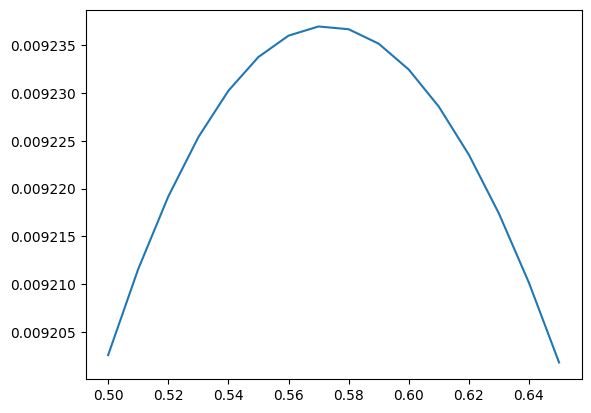

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f63a7158fd0>

In [3]:
obj(x) = nash_in_nash( [x,.57], [.5,.5] , 1.5)[1]
xs = collect(50:65)/100
objs = []
for x=xs 
    append!(objs,obj(x))
end 

plot(xs,objs)

In [4]:
function bargain_helper(phi, mu, alpha; mc=0.)
    """solve each firm 1s optimization holding theta 2 fixed"""
    
    obj1(phi0) = -1*nash_in_nash( [phi0[1], phi[2]] , mu, alpha ; mc=mc)[1]
    res1 =  optimize(obj1, [phi[1]], BFGS())

    obj2(phi0) = -1*nash_in_nash( [phi[1], phi0[1]] , mu, alpha; mc=mc)[2]
    res2 =  optimize(obj2, [phi[2]], BFGS())
    
    return [ res1.minimizer[1], res2.minimizer[1] ]
end

println( bargain_helper([2.,2.],[.5,.5], 1) )

[0.748419, 0.748419]


In [5]:
function simult_bargain(mu, alpha; mc=0.)
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  5.
    phi = [alpha, alpha]

    maxiter = 10
    while (maxiter >=0) & (diff > 10e-7)
        #seems as though there is a contraction mapping here, need to think more about why
        phi_new = bargain_helper(phi, mu, alpha; mc=mc)
        
        #update loop variables
        diff = maximum( abs.(phi - phi_new) )
        maxiter = maxiter-1
        
        #update phi
        phi = phi_new
    end
    return phi
end
    
print(simult_bargain([.5,.5], 1.5) )

[0.572178, 0.572178]

In [6]:
function bargain_helper_seq(phi1, mu, alpha; mc=0.)
    """ solve firm 1s optimization holding theta 2 fixed """
    obj1(phi2) = -1*nash_in_nash( [ phi1, phi2[1] ] , mu, alpha; mc=mc)[2]
    res =  optimize(obj1, [phi1], LBFGS())
    return res.minimizer[1]
end


function outside_profit(phi1,mu,alpha) #not sure if this works...
    mkt_share1(p) = exp(-alpha * p)/(1+exp(-alpha *p))
    profits1(p) = (p-mu[1]*phi1)*mkt_share1(p)
    obj(p) = -1*profits(p[1])
    res1 =  optimize(obj, [phi1], BFGS())
    return mkt_share1(res1.minimizer[1])
end


function seq_obj(phi1, mu, alpha; mc=0.)
    """ theta1 is a guess for the first stage """
    phi1 = max(phi1,0)
    phi2 = bargain_helper_seq(phi1, mu, alpha; mc=mc)
    #figure out mkt share with 1 firm ... 
    #pi10 = outside_profit(phi1,mu,alpha)
    return nash_in_nash([phi1, phi2], mu, alpha; mc=mc)[1]
end

bargain_helper_seq(1., [.5,.5], 1)

seq_obj(1., [.5,.5], 1)

0.020420676238090938

In [7]:
function seq_bargain(mu, alpha; mc=0.)
    """solve the bargaining problems seperately,
    then solve for the solution"""
    
    obj1(phi10) = -1*seq_obj(phi10[1], mu, alpha; mc=mc)
    res = optimize(obj1, [2.], LBFGS())
    phi1  = res.minimizer[1]
    phi2 = bargain_helper([phi1,phi1], mu, alpha; mc=mc)[2]
    return [phi1, phi2]
end

print(seq_bargain([.2,.2], .7; mc=-1))

[0.957519, 2.45445]

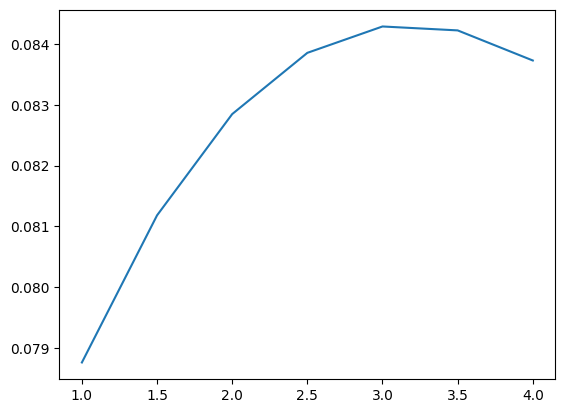

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f63a662f0f0>

In [8]:
obj(x) = seq_obj( x, [.2,.2] , 0.5 )
xs = collect(1:.5:4)
objs = []
for x=xs 
    append!(objs,obj(x))
end 

plot(xs,objs)

In [9]:
function make_table(steps, mu)
    """the argument is 
    steps = min_arg, max_arg, no_step """
    
    min_arg, max_arg, no_step = steps    
    step_size = (max_arg - min_arg)/no_step
    indep_var = min_arg:step_size:max_arg
    
    for eq_type= ["Simultaneous", "Sequential"]
        
        result1 = []
        result2 = []
        
        for alpha=indep_var
            
            phi = [0.,0.]
            
            if eq_type == "Simultaneous"
                phi = simult_bargain(mu, alpha)
            else
                phi = seq_bargain(mu, alpha)
            end


            price, profits = price_profits(phi,mu,alpha)
            share = market_shares(price, alpha)
            hosp = sum(mu .* share .* phi)
            
            append!(result1, [[alpha, phi[1], share[1], price[1], profits[1], hosp ]] ) 
            append!(result2, [[alpha, phi[2], share[2], price[2], profits[2], hosp]] ) 
        end
        
        println("\n",eq_type, "\n" )
        for line =result1
            print( round(line[1],sigdigits=3) )
            for i=2:6
                print( " & ")
                print(round(line[i],sigdigits=3) )
            end
            print(" \\\\\\\\ \n")
        end   
        print('\n')
        
        for line =result2
            print( round(line[1],sigdigits=3) )
            for i=2:6
                print( " & ") 
                print(round(line[i],sigdigits=3) )
            end
            print(" \\\\\\\\ \n")
        end
    end
    

end

    
make_table( (.5,1,5), [.2,.2] )


Simultaneous

0.5 & 4.29 & 0.144 & 3.19 & 0.337 & 0.247 \\\\ 
0.6 & 3.58 & 0.144 & 2.66 & 0.281 & 0.206 \\\\ 
0.7 & 3.07 & 0.144 & 2.28 & 0.24 & 0.177 \\\\ 
0.8 & 2.68 & 0.144 & 2.0 & 0.21 & 0.155 \\\\ 
0.9 & 2.38 & 0.144 & 1.77 & 0.187 & 0.137 \\\\ 
1.0 & 2.15 & 0.144 & 1.6 & 0.168 & 0.124 \\\\ 

0.5 & 4.29 & 0.144 & 3.19 & 0.337 & 0.247 \\\\ 
0.6 & 3.58 & 0.144 & 2.66 & 0.281 & 0.206 \\\\ 
0.7 & 3.07 & 0.144 & 2.28 & 0.24 & 0.177 \\\\ 
0.8 & 2.68 & 0.144 & 2.0 & 0.21 & 0.155 \\\\ 
0.9 & 2.38 & 0.144 & 1.77 & 0.187 & 0.137 \\\\ 
1.0 & 2.15 & 0.144 & 1.6 & 0.168 & 0.124 \\\\ 

Sequential

0.5 & 3.32 & 0.155 & 3.03 & 0.367 & 0.23 \\\\ 
0.6 & 2.65 & 0.157 & 2.51 & 0.309 & 0.189 \\\\ 
0.7 & 2.27 & 0.157 & 2.15 & 0.265 & 0.162 \\\\ 
0.8 & 2.0 & 0.156 & 1.88 & 0.232 & 0.142 \\\\ 
0.9 & 2.0 & 0.152 & 1.71 & 0.199 & 0.131 \\\\ 
1.0 & 1.5 & 0.159 & 1.49 & 0.189 & 0.112 \\\\ 

0.5 & 4.54 & 0.14 & 3.23 & 0.326 & 0.23 \\\\ 
0.6 & 3.81 & 0.139 & 2.7 & 0.27 & 0.189 \\\\ 
0.7 & 3.27 & 0.139 & 2.31 

In [10]:
#simulate a random cost



In [11]:
function gen_data(mu, alpha)
    """the argument is 
    steps = min_arg, max_arg, no_step """
    
    gen_cols, cols = ["alpha","hosp"], ["phi","s","p","profits"]
    
    d = Normal()
    xs = rand(d, 1000)
    
    for eq_type= ["Simultaneous", "Sequential"]
        
        result = []
        
        for x=xs
            
            phi = [0.,0.]
            
            if eq_type == "Simultaneous"
                phi = simult_bargain(mu, alpha;mc=x)
            else
                phi = seq_bargain(mu, alpha;mc=x)
            end


            price, profits = price_profits(phi,mu,alpha)
            share = market_shares(price, alpha)
            hosp = sum(mu .* share .* phi)
            
            append!(result,[[alpha, hosp, phi[1], share[1], price[1], profits[1],
                        phi[2], share[2], price[2], profits[2]]] ) 
        end
        
        
        
        io = open("data/$(eq_type).csv", "w")
        
        #write header
 
        for col=gen_cols
            print(io, "$(col),")
        end
        
        for player=[1,2]
            for col=cols
                print(io,"$(col)$(player),")
            end
        end
        print(io,"\n")
        
        for line=result
            for value=line
                print(io,"$(value),")
            end
            print(io,"\n")
        end
        
        close(io)
    end
end

    
gen_data([.2,.2],.7 )